<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/multi_modal_video_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal RAG for processing videos using LanceDB vectorstore

In this notebook, we showcase a Multimodal RAG architecture designed for video processing. We utilize OpenAI [CLIP](https://github.com/openai/CLIP) to generate multimodal embeddings. Furthermore, we use [LanceDBVectorStore](https://docs.llamaindex.ai/en/latest/examples/vector_stores/LanceDBIndexDemo.html#) for efficient vector storage.



Steps:

Download YouTube video

Extract frames (images)

Extract audio

Transcribe audio into text

Store extracted frames + text on disk

Create a multimodal vector database (LanceDB)

Insert images + text into the vector store using LlamaIndex

Embed both images + text

Perform multimodal retrieval based on a query

Fetch k-nearest text chunks + image frames

Show retrieved frames

In [ ]:
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-multi-modal-llms-openai

  Using cached llama_index_multi_modal_llms_openai-0.6.2-py3-none-any.whl.metadata (440 bytes)
  Using cached llama_index_llms_openai-0.6.10-py3-none-any.whl.metadata (3.0 kB)
Using cached llama_index_multi_modal_llms_openai-0.6.2-py3-none-any.whl (3.4 kB)
Using cached llama_index_llms_openai-0.6.10-py3-none-any.whl (26 kB)


In [ ]:
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-embeddings-clip

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install -U openai-whisper
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install lancedb
%pip install moviepy

%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile

INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.5/329.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
! pip install yt-dlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.6 MB/s eta 0:00:00


In [ ]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
import yt_dlp as ydl

from pprint import pprint

#### Set configuration for input below

In [ ]:
video_url = "https://www.youtube.com/watch?v=d_qvLDhkg00"
output_video_path = "./video_data/"
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

filepath = output_video_path + "input_vid.mp4"
Path(output_folder).mkdir(parents=True, exist_ok=True)

#### Download and process videos into appropriate format for generating/storing embeddings

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 7:
                break

In [ ]:
def download_video(url, output_path):
    video_out = output_path + "/input_vid.mp4"

    ydl_opts = {
        'format': 'bestvideo+bestaudio/best',
        'outtmpl': video_out,
        'merge_output_format': 'mp4'
    }

    with ydl.YoutubeDL(ydl_opts) as y:
        info = y.extract_info(url, download=True)

    metadata = {
        "Author": info.get("uploader"),
        "Title": info.get("title"),
        "Views": info.get("view_count")
    }

    return metadata


def video_to_images(video_path, output_folder):
    """
    Convert a video to a sequence of images and save them to the output folder.

    Parameters:
    video_path (str): The path to the video file.
    output_folder (str): The path to the folder to save the images to.

    """
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(
        os.path.join(output_folder, "frame%04d.png"), fps=0.2
    )


def video_to_audio(video_path, output_audio_path):
    """
    Convert a video to audio and save it to the output path.

    Parameters:
    video_path (str): The path to the video file.
    output_audio_path (str): The path to save the audio to.

    """
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)


def audio_to_text(audio_path):
    """
    Convert audio to text using the SpeechRecognition library.

    Parameters:
    audio_path (str): The path to the audio file.

    Returns:
    test (str): The text recognized from the audio.

    """
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)

    with audio as source:
        # Record the audio data
        audio_data = recognizer.record(source)

        try:
            # Recognize the speech
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
        except sr.RequestError as e:
            print(f"Could not request results from service; {e}")

    return text

In [ ]:
try:
    metadata_vid = download_video(video_url, output_video_path)
    video_to_images(filepath, output_folder)
    video_to_audio(filepath, output_audio_path)
    text_data = audio_to_text(output_audio_path)

    with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
    print("Text data saved to file")
    file.close()
    os.remove(output_audio_path)
    print("Audio file removed")

except Exception as e:
    raise e

[youtube] Extracting URL: https://www.youtube.com/watch?v=d_qvLDhkg00
[youtube] d_qvLDhkg00: Downloading webpage


[youtube] d_qvLDhkg00: Downloading android sdkless player API JSON
[youtube] d_qvLDhkg00: Downloading web safari player API JSON


[youtube] d_qvLDhkg00: Downloading m3u8 information


[info] d_qvLDhkg00: Downloading 1 format(s): 401+251-1
[download] Sleeping 4.00 seconds as required by the site...
[download] Destination: ./video_data//input_vid.f401.mp4
[download] 100% of  162.57MiB in 00:00:16 at 9.63MiB/s   
[download] Destination: ./video_data//input_vid.f251-1.webm
[download] 100% of   13.04MiB in 00:00:00 at 20.30MiB/s  
[Merger] Merging formats into "./video_data//input_vid.mp4"
Deleting original file ./video_data//input_vid.f401.mp4 (pass -k to keep)
Deleting original file ./video_data//input_vid.f251-1.webm (pass -k to keep)
Moviepy - Writing frames ./mixed_data/frame%04d.png.


Moviepy - Done writing frames ./mixed_data/frame%04d.png.
MoviePy - Writing audio in ./mixed_data/output_audio.wav


MoviePy - Done.


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 203MiB/s]


Text data saved to file
Audio file removed


#### Create the multi-modal index

In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext

from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore


from llama_index.core import SimpleDirectoryReader

In [ ]:
# os.environ["OPENAI_API_KEY"] = set your key here

In [ ]:
text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader(output_folder).load_data()

index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

#### Use index as retriever to fetch top k (5 in this example) results from the multimodal vector index

In [ ]:
retriever_engine = index.as_retriever(
    similarity_top_k=5, image_similarity_top_k=5
)

#### Set the RAG  prompt template

In [ ]:
import json

metadata_str = json.dumps(metadata_vid)

qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the video, \
 accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

#### Retrieve most similar text/image embeddings baseed on user query from the DB

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

#### Add query now, fetch relevant details including images and augment the prompt template

**Node ID:** ce5562fe-0510-4a12-a2ed-3afa778b069e<br>**Similarity:** 0.7475027441978455<br>**Text:** The basic function underlying a normal distribution, aka a Gaussian, is e to the negative x squared. But you might wonder why this function? Of all the expressions we could dream up that give you s...<br>

**Node ID:** c657595e-cdc8-4cd0-aa2f-e3d9b3092dcd<br>**Similarity:** 0.7178276181221008<br>**Text:** One common approach to proving this theorem involves two separate steps. The first step is to show that for all the different finite variance distributions you might start with, there exists a sing...<br>

**Node ID:** 1797f037-57b9-49d0-887e-7b1c09f5b040<br>**Similarity:** 0.7024105191230774<br>**Text:** So when you're computing the integral, finding this area, all of this term here behaves like it was just some number, and you can factor it out. This is the important point. All of the stuff that's...<br>

**Node ID:** 921d152b-d658-498e-a16d-7bc63fa8a82e<br>**Similarity:** 0.6844450235366821<br>**Text:** And the way I'd like to do this is by first peeling away all of the constants associated with the actual distribution, and just showing the computation for the simplified form, e to the negative x ...<br>

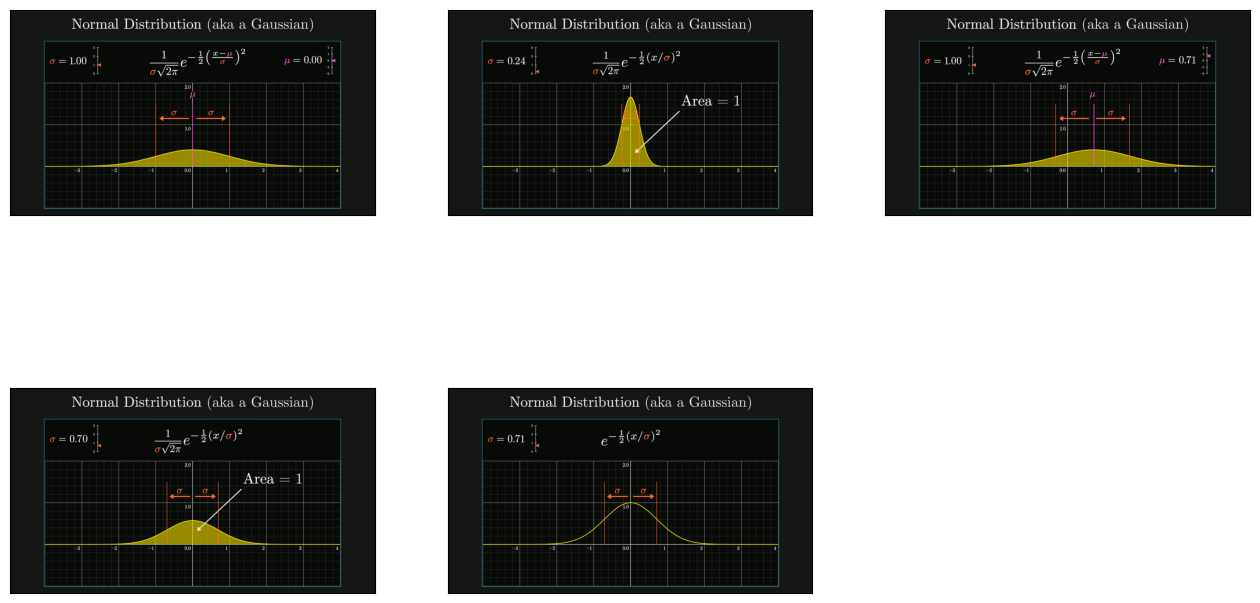

In [ ]:
query_str = "Using examples from video, explain all things covered in the video regarding the gaussian function"

img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)
image_documents = SimpleDirectoryReader(
    input_dir=output_folder, input_files=img
).load_data()
context_str = "".join(txt)
plot_images(img)

#### Generate final response using GPT4V

In [ ]:
# set your api key for this to work
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key="", max_new_tokens=1500
) # api key here


response_1 = openai_mm_llm.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str, query_str=query_str, metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

pprint(response_1.text)

('The video by 3Blue1Brown, titled "A pretty reason why Gaussian + Gaussian = '
 'Gaussian," covers several aspects of the Gaussian function, also known as '
 "the normal distribution. Here's a summary of the key points discussed in the "
 'video:\n'
 '\n'
 '1. **Central Limit Theorem**: The video begins by discussing the central '
 'limit theorem, which states that the sum of multiple copies of a random '
 'variable tends to look like a normal distribution. As the number of '
 'variables increases, the approximation to a normal distribution becomes '
 'better.\n'
 '\n'
 '2. **Convolution of Random Variables**: The process of adding two random '
 'variables is mathematically represented by a convolution of their respective '
 'distributions. The video explains the concept of convolution and how it is '
 'used to find the distribution of the sum of two random variables.\n'
 '\n'
 '3. **Gaussian Function**: The Gaussian function is more complex than just '
 '\\( e^{-x^2} \\). The full fo